<a href="https://colab.research.google.com/github/ScientistLim/ProjectAW/blob/min/%EA%B8%B0%EC%A1%B4%EC%BD%94%EB%93%9C_%EB%8B%A4%EB%B3%80%EC%88%98_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

   conductivity  feed_pressure
0        0.2500       0.000000
1        0.2500       0.076875
2        0.2500       0.114375
3        0.3125       0.496875
4        0.3125       3.421875


<ipython-input-16-3b57fb82de43>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected.drop(outlier_idx, axis=0, inplace=True)
<ipython-input-16-3b57fb82de43>:111: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 1, 1)


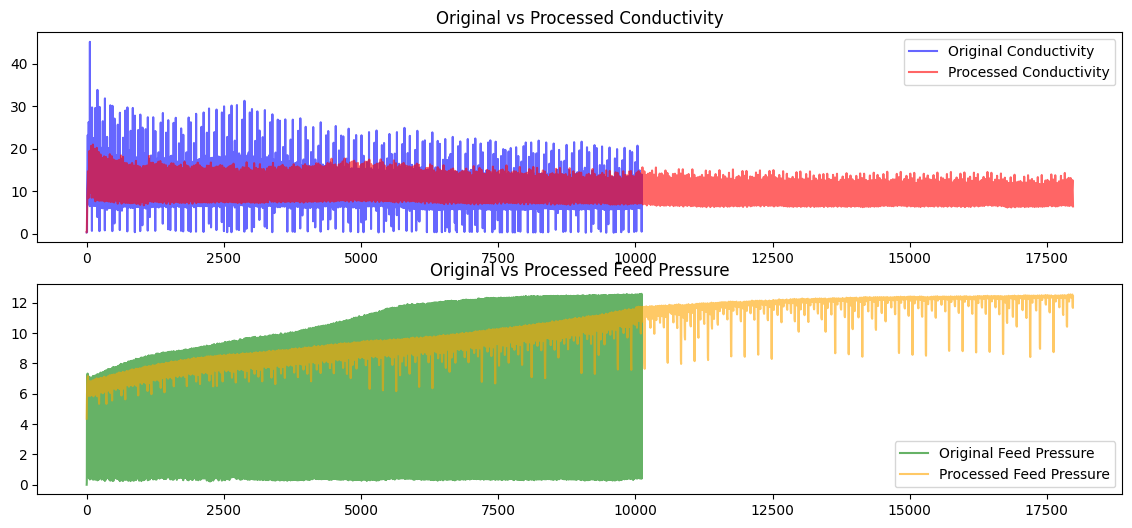

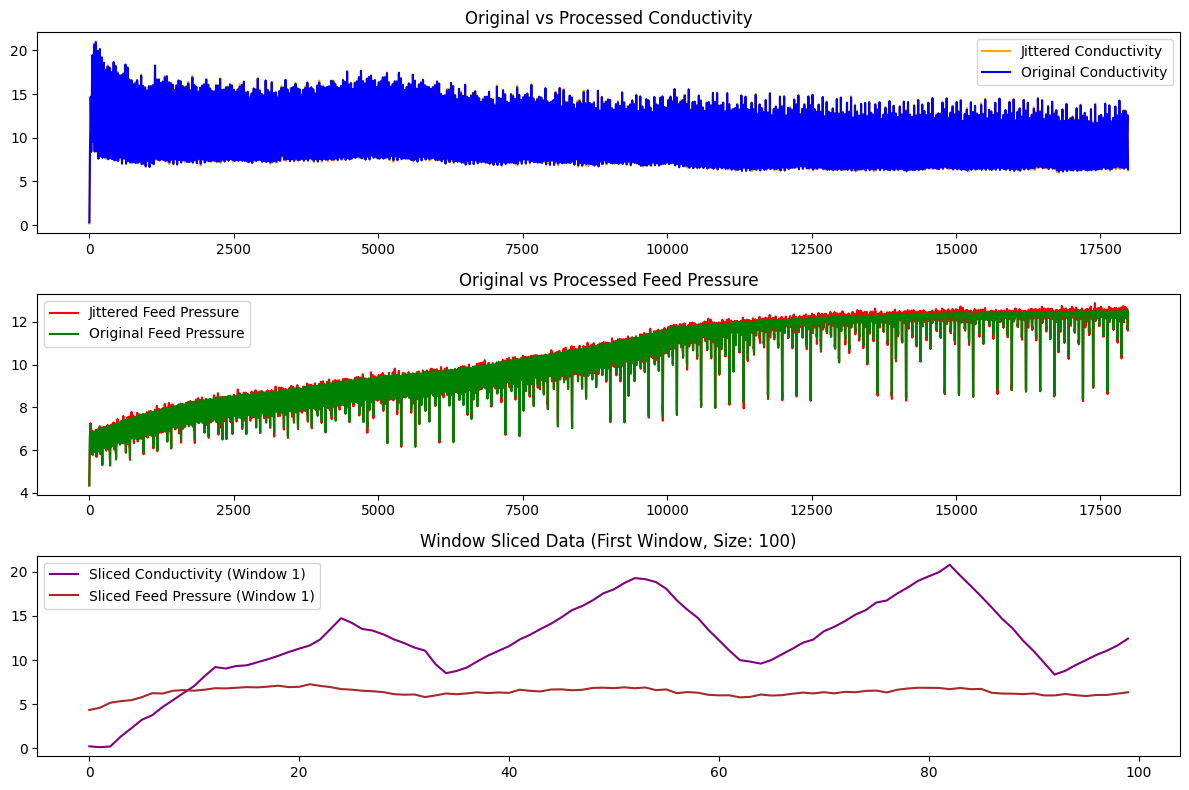

In [16]:
from google.colab import files
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
%matplotlib inline

# # CSV 파일 업로드
# uploaded = files.upload()
# file_name = list(uploaded.keys())[0]
file_name = '/content/통합운전데이터.rev01.csv'
df = pd.read_csv(file_name)

# E열 (처리수 전기전도도), K열 (RO유입압력) 추출
df_selected = df[['RO 처리수 전기전도도(uS/cm)', 'RO유입 압력(bar)']]
df_selected.columns = ['conductivity', 'feed_pressure']

# 데이터 확인
print(df_selected.head())

# 원본 데이터 저장 (전혀 처리하지 않은 데이터)
original_conductivity = df_selected['conductivity'].values
original_feed_pressure = df_selected['feed_pressure'].values

################## 전처리 시작 #########################

# 아웃라이어 제거 함수 (IQR 방식 적용)
def get_outlier(df=None, column=None, weight=1.5):
    quantile_25 = np.percentile(df[column].values, 25)
    quantile_75 = np.percentile(df[column].values, 75)

    IQR = quantile_75 - quantile_25
    IQR_weight = IQR * weight

    lowest = quantile_25 - IQR_weight * 1.423 / 1.5
    highest = quantile_75 + IQR_weight * 1.6 / 1.5

    outlier_idx = df[column][(df[column] < lowest) | (df[column] > highest)].index
    return outlier_idx

# 두 변수에 대한 이상치 제거(개별적으로 적용)
for column in ['conductivity', 'feed_pressure']:
    outlier_idx = get_outlier(df=df_selected, column=column, weight=1.5)
    df_selected.drop(outlier_idx, axis=0, inplace=True)

# 각 변수에 대해 별도의 Min-Max 스케일러 적용
scaler_conductivity = MinMaxScaler()
scaler_feed_pressure = MinMaxScaler()

scaled_conductivity = scaler_conductivity.fit_transform(df_selected['conductivity'].values.reshape(-1, 1))
scaled_feed_pressure = scaler_feed_pressure.fit_transform(df_selected['feed_pressure'].values.reshape(-1, 1))

# 데이터 스무딩 및 인터폴레이션 함수 정의
def smooth_and_interpolate(data, window_size):
    def moving_average(data, window_size):
        return np.convolve(data, np.ones(window_size) / window_size, mode='same')

    def add_padding(data, padding_size):
        start_padding = np.full(padding_size, data[0])
        end_padding = np.full(padding_size, data[-1])
        return np.concatenate([start_padding, data, end_padding])

    # 패딩 적용
    padded_data = add_padding(data.flatten(), window_size)

    # 이동 평균 적용
    rolled_data = moving_average(padded_data, window_size)

    # 패딩 제거
    rolled_data_trimmed = rolled_data[window_size:-window_size]

    # 새로운 x축 포인트 생성 (인터폴레이션)
    x_new = np.linspace(0, len(rolled_data_trimmed) - 1, len(data) * 2)
    f_interpolated = interp1d(range(len(rolled_data_trimmed)), rolled_data_trimmed, kind='linear')
    interpolated_data = f_interpolated(x_new)

    return interpolated_data

# 이동 평균 윈도우 크기
window_size = 5

# 데이터 스무딩 및 인터폴레이션
smoothed_conductivity = smooth_and_interpolate(scaled_conductivity, window_size)
smoothed_feed_pressure = smooth_and_interpolate(scaled_feed_pressure, window_size)

# 스케일 역변환 (원래 데이터 범위로 복원)
smoothed_conductivity = scaler_conductivity.inverse_transform(smoothed_conductivity.reshape(-1, 1))
smoothed_feed_pressure = scaler_feed_pressure.inverse_transform(smoothed_feed_pressure.reshape(-1, 1))

# 전처리된 최종 데이터 저장
final_processed_df = pd.DataFrame({
    'Processed Conductivity': smoothed_conductivity.flatten(),
    'Processed Feed Pressure': smoothed_feed_pressure.flatten()
})

# # 결과를 CSV 파일로 저장
# final_processed_df.to_csv('final_processed_data.csv', index=False)

# files.download('final_processed_data.csv')

# 결과 확인 (처리된 데이터의 일부를 시각화)
plt.figure(figsize=(14, 6))
plt.plot(final_processed_df['Processed Conductivity'], label='Processed Conductivity', color='blue', alpha=0.6)
plt.plot(final_processed_df['Processed Feed Pressure'], label='Processed Feed Pressure', color='green', alpha=0.6)
plt.title('Processed Data Visualization')
plt.legend()

# 원본 vs 전처리된 Conductivity 데이터
plt.subplot(2, 1, 1)
plt.plot(original_conductivity, label='Original Conductivity', color='blue', alpha=0.6)
plt.plot(final_processed_df['Processed Conductivity'], label='Processed Conductivity', color='red', alpha=0.6)
plt.title('Original vs Processed Conductivity')
plt.legend()

# 원본 vs 전처리된 Feed Pressure 데이터
plt.subplot(2, 1, 2)
plt.plot(original_feed_pressure, label='Original Feed Pressure', color='green', alpha=0.6)
plt.plot(final_processed_df['Processed Feed Pressure'], label='Processed Feed Pressure', color='orange', alpha=0.6)
plt.title('Original vs Processed Feed Pressure')
plt.legend()

plt.show()

################## 전처리 끝, 증강 시작 #########################

# Jittering 적용 함수: 미세한 Gaussian 노이즈를 추가
def apply_jittering(data, noise_level=0.01):
    jittered_data = data.copy()
    jittered_data['Processed Conductivity'] += np.random.normal(0, noise_level, size=len(data))
    jittered_data['Processed Feed Pressure'] += np.random.normal(0, noise_level, size=len(data))
    return jittered_data

# 윈도우 슬라이싱 적용 함수: 시계열 데이터를 일정 크기의 윈도우로 자름
def apply_window_slicing(data, window_size=10, step_size=1):
    sliced_data = []
    num_samples = len(data)

    for start in range(0, num_samples - window_size + 1, step_size):
        window = data.iloc[start:start + window_size].copy()
        sliced_data.append(window)

    return sliced_data

# 데이터 증강 및 시각화 함수
def augment_and_visualize(data, noise_level=0.01, window_size=10, step_size=1):

    # Jittering 적용
    jittered_data = apply_jittering(data, noise_level=noise_level)

    # 윈도우 슬라이싱 적용
    sliced_data = apply_window_slicing(jittered_data, window_size=window_size, step_size=step_size)

    # 시각화
    visualize_data(data, jittered_data, sliced_data)

# 시각화 함수
def visualize_data(original_data, jittered_data, sliced_data):
    # 원본 데이터 시각화
    plt.figure(figsize=(12, 8))

    plt.subplot(3, 1, 1)
    plt.plot(jittered_data['Processed Conductivity'], label="Jittered Conductivity", color='orange')
    plt.plot(original_data['Processed Conductivity'], label="Original Conductivity", color='blue')
    plt.title("Original vs Processed Conductivity")
    plt.legend()

    # Jittering 적용된 데이터 시각화
    plt.subplot(3, 1, 2)
    plt.plot(jittered_data['Processed Feed Pressure'], label="Jittered Feed Pressure", color='red')
    plt.plot(original_data['Processed Feed Pressure'], label="Original Feed Pressure", color='green')
    plt.title("Original vs Processed Feed Pressure")
    plt.legend()

    # 윈도우 슬라이싱 시각화 (첫 번째 윈도우만)
    plt.subplot(3, 1, 3)
    first_window = sliced_data[0]  # 첫 번째 윈도우만 시각화
    plt.plot(first_window['Processed Conductivity'], label="Sliced Conductivity (Window 1)", color='purple')
    plt.plot(first_window['Processed Feed Pressure'], label="Sliced Feed Pressure (Window 1)", color='brown')
    plt.title(f"Window Sliced Data (First Window, Size: {len(first_window)})")
    plt.legend()

    plt.tight_layout()
    plt.show()

augment_and_visualize(final_processed_df, noise_level=0.1, window_size=100, step_size=1)
